In [1]:
%matplotlib inline
%precision 16
import numpy
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt
from scipy.integrate import quad

## Test for backward euler method

Set variables related to change of variables: $(S,v)\rightarrow(\xi, \eta)$

In [2]:
K     = 1200.0

# Stock spatial space
S_max = 2000.0
S_min = 400.0
alpha = S_max - S_min

# Variance space
v_max = 0.1
v_min = 0.0
beta  = v_max - v_min

c1    = numpy.arcsinh( (S_max - K)/alpha )
c2    = numpy.arcsinh( (S_min - K)/alpha )
#d1    = numpy.arcsinh( (v_max - v_min)/beta )
d1    = numpy.arcsinh( v_max/beta )
d2    = numpy.arcsinh( v_min/beta )

Set coefficients of heston pde

In [3]:
rho   = -0.5
sigma = 0.3
r     = 0.03
q     = 0.0
kappa = 2
theta = 0.05

Set grid

In [4]:
#t_final = 0.02
N = 40
M = 20
L = 100

xi  = numpy.linspace(0, 1, N+2) 
eta = numpy.linspace(0, 1, M+2)
#t   = numpy.linspace(0, t_final, L)

xi = xi[1:-1]
eta = eta[1:-1]

delta_xi  =  xi[1] -  xi[0]
delta_eta = eta[1] - eta[0]
#delta_t   =   t[1] -   t[0]

delta_t = 1e-4
t_final = 200 * delta_t

print delta_xi
print delta_eta
print delta_xi * delta_eta
print delta_t

0.0243902439024
0.047619047619
0.00116144018583
0.0001


Common function that needs during entire run time

In [5]:
S         = lambda xi: K + alpha * numpy.sinh( c1*xi + c2*(1-xi) )
dSdxi     = lambda xi: alpha * numpy.cosh( c1*xi + c2*(1-xi) ) * (c1 - c2)
d2Sdxi2   = lambda xi: alpha * numpy.sinh( c1*xi + c2*(1-xi) ) * (c1 - c2)**2

v         = lambda eta: beta*numpy.sinh( d1*eta + d2*(1-eta) )
dvdeta    = lambda eta: numpy.cosh( d1*eta ) * (d1-d2) * beta
d2vdeta2  = lambda eta: numpy.sinh( d1*eta ) * (d1-d2)**2 * beta

Allocate solution vector U

In [6]:
#U = numpy.empty([N+2, M+2])
U_old = numpy.zeros(N*M)
U_new = numpy.zeros(N*M)

In [7]:
T = t_final
_lambda = 0.0

In [8]:
def Heston_Integral(phi, K, S, v, T, r, kappa, theta, sigma, rho, _lambda, j): 
    u_1 = 1.0 / 2.0
    u_2 = - 1.0 / 2.0
    a = kappa * theta
    rspi = rho * sigma * phi * 1j
    tau = T
    
    b_1 = kappa + _lambda - rho * sigma
    b_2 = kappa + _lambda
    
    d_1 = numpy.sqrt((rspi - b_1)**2 - sigma**2 * (2.0 * u_1 * phi * 1j - phi**2))
    d_2 = numpy.sqrt((rho * sigma * phi * 1j - b_2)**2 - sigma**2 * (2.0 * u_2 * phi * 1j - phi**2))
    
    g_1 = (b_1 - rspi + d_1) / (b_1 - rspi - d_1)
    g_2 = (b_2 - rspi + d_2) / (b_2 - rspi - d_2)
   
    D_1 = (b_1 - rspi + d_1) / sigma**2 * ((1.0 - numpy.exp(d_1 * tau)) / (1.0 - g_1 * numpy.exp(d_1 * r)))
    D_2 = (b_2 - rspi + d_2) / sigma**2 * ((1.0 - numpy.exp(d_2 * tau)) / (1.0 - g_2 * numpy.exp(d_2 * r)))
    
    C_1 = r * phi * 1j * tau + a / sigma**2 * ((b_1 - rspi + d_1) * tau - 2.0 * numpy.log((1.0 - g_1 * numpy.exp(d_1 * tau))/(1.0 - g_1)))
    C_2 = r * phi * 1j * tau + a / sigma**2 * ((b_2 - rspi + d_2) * tau - 2.0 * numpy.log((1.0 - g_2 * numpy.exp(d_2 * tau))/(1.0 - g_2)))   
    
    f_1 = numpy.exp(C_1 + D_1 * v + 1j * phi * numpy.log(S))
    f_2 = numpy.exp(C_2 + D_2 * v + 1j * phi * numpy.log(S))
    
    if(j==1):
        return numpy.real((numpy.exp(-1j * phi * numpy.log(K)) * f_1)/(1j * phi))
    elif(j==2):
        return numpy.real((numpy.exp(-1j * phi * numpy.log(K)) * f_2)/(1j * phi))

In [9]:
def Exact_Solution(S, v): 
    P_1 = 0.5 + 1.0 / numpy.pi * \
          quad(Heston_Integral, 0, 1000, args=(K, S, v, T, r, kappa, theta, sigma, rho, _lambda, 1))[0]
    P_2 = 0.5 + 1.0 / numpy.pi * \
          quad(Heston_Integral, 0, 1000, args=(K, S, v, T, r, kappa, theta, sigma, rho, _lambda, 2))[0]
    
    Call = S * P_1 - K * numpy.exp(- r * (T - 0.0)) * P_2
    return Call

Set function to construct matrix A

In [10]:
a = lambda i,j: delta_t*rho*sigma/(4.0*delta_xi*delta_eta)*v(eta[j])*S(xi[i])/(dSdxi(xi[i]) * dvdeta(eta[j]))
b = lambda i,j: sigma**2 * delta_t/(2.0*delta_eta**2)*v(eta[j])/dvdeta(eta[j])**2 - \
                delta_t/(2.0*delta_eta)*(kappa*(theta-v(eta[j]))/dvdeta(eta[j]) - \
                0.5*sigma**2*v(eta[j])*d2vdeta2(eta[j])/dvdeta(eta[j])**3)
c = lambda i,j: delta_t/delta_xi**2*v(eta[j])*S(xi[i])**2/dSdxi(xi[i])**2 - \
                delta_t/(2.0*delta_xi)*((r-q)*S(xi[i])/dSdxi(xi[i]) - 0.5*v(eta[j])*S(xi[i])**2*d2Sdxi2(xi[i])/dSdxi(xi[i])**3)
d = lambda i,j: 1 + r*delta_t + delta_t/delta_xi**2 * v(eta[j])*S(xi[i])**2/dSdxi(xi[i])**2 + \
                sigma**2*delta_t/delta_eta**2*v(eta[j])/dvdeta(eta[j])**2
e = lambda i,j: delta_t/delta_xi**2*v(eta[j])*S(xi[i])**2/dSdxi(xi[i])**2 + \
                delta_t/(2*delta_xi)*((r-q)*S(xi[i])/dSdxi(xi[i]) - 0.5*v(eta[j])*S(xi[i])**2*d2Sdxi2(xi[i])/dSdxi(xi[i])**3)
f = lambda i,j: sigma**2*delta_t/(2*delta_eta**2)*v(eta[j])/dvdeta(eta[j])**2 + \
                delta_t/(2.0*delta_eta)*(kappa*(theta - v(eta[j]))/dvdeta(eta[j]) - 0.5*sigma**2*v(eta[j])*d2vdeta2(eta[j])/dvdeta(eta[j])**3)

Allocate memory

In [11]:
A = numpy.zeros([M*N, M*N])
rhs = numpy.zeros(N*M)

Construct matrix A

In [12]:
for irow in range(M*N):
    # U_hat[irow] == U_interior[i,j]
    i = irow/M
    j = numpy.mod(irow, M)
    
    if( i == 0 ):
        if (j == 0):
            A[irow, irow]         =  d(i,j)
            A[irow, irow + 1]     = -f(i,j)
            A[irow, irow + M]     = -e(i,j)
            A[irow, irow + M + 1] = -a(i,j)
            rhs[irow] =  a(i,j)*Exact_Solution(S(0),v(0)) \
                        +b(i,j)*Exact_Solution(S(xi[i]),v(0)) \
                        -a(i,j)*Exact_Solution(S(xi[i+1]),v(0)) \
                        +c(i,j)*Exact_Solution(S(0),v(eta[j]))\
                        -a(i,j)*Exact_Solution(S(0),v(eta[j+1]))
        elif (j == M-1):
            A[irow, irow - 1]     = -b(i,j)
            A[irow, irow]         =  d(i,j)
            A[irow, irow + M - 1] =  a(i,j)
            A[irow, irow + M]     = -e(i,j)
            rhs[irow] = -a(i,j)*Exact_Solution(S(0),v(1))\
                        +f(i,j)*Exact_Solution(S(xi[i]),v(1))\
                        +a(i,j)*Exact_Solution(S(xi[i+1]),v(1))\
                        +c(i,j)*Exact_Solution(S(0),v(eta[j]))\
                        +a(i,j)*Exact_Solution(S(0),v(eta[j-1]))
        else: # Add term for bc condition
            A[irow, irow - 1]     = -b(i,j)
            A[irow, irow]         =  d(i,j)
            A[irow, irow + 1]     = -f(i,j)
            A[irow, irow + M - 1] =  a(i,j)
            A[irow, irow + M]     = -e(i,j)
            A[irow, irow + M + 1] = -a(i,j)
            rhs[irow] = -a(i,j)*Exact_Solution(S(0),v(eta[j+1]))\
                        +c(i,j)*Exact_Solution(S(0),v(eta[j]))\
                        +a(i,j)*Exact_Solution(S(0),v(eta[j-1]))
    elif (i == N-1):
        if (j == 0):
            A[irow, irow - M ]    = -c(i,j)
            A[irow, irow - M + 1] =  a(i,j)
            A[irow, irow]         =  d(i,j)
            A[irow, irow + 1]     = -f(i,j)
            rhs[irow] = -a(i,j)*Exact_Solution(S(1),v(0))\
                        +b(i,j)*Exact_Solution(S(xi[i]),v(0))\
                        +a(i,j)*Exact_Solution(S(xi[i-1]),v(0))\
                        +e(i,j)*Exact_Solution(S(1),v(eta[j]))\
                        +a(i,j)*Exact_Solution(S(1),v(eta[j+1]))
        elif (j == M-1):
            A[irow, irow - M - 1] = -a(i,j)
            A[irow, irow - M ]    = -c(i,j)
            A[irow, irow - 1]     = -b(i,j)
            A[irow, irow]         =  d(i,j)
            rhs[irow] =  a(i,j)*Exact_Solution(S(1),v(1))\
                        +f(i,j)*Exact_Solution(S(xi[i]),v(1))\
                        -a(i,j)*Exact_Solution(S(xi[i-1]),v(1))\
                        +e(i,j)*Exact_Solution(S(1),v(eta[j]))\
                        +a(i,j)*Exact_Solution(S(1),v(eta[j-1]))
        else:
            A[irow, irow - M - 1] = -a(i,j)
            A[irow, irow - M ]    = -c(i,j)
            A[irow, irow - M + 1] =  a(i,j)
            A[irow, irow - 1]     = -b(i,j)
            A[irow, irow]         =  d(i,j)
            A[irow, irow + 1]     = -f(i,j)
            rhs[irow] = -a(i,j)*Exact_Solution(S(1),v(eta[j-1]))\
                        +e(i,j)*Exact_Solution(S(1),v(eta[j]))\
                        +a(i,j)*Exact_Solution(S(1),v(eta[j+1]))
    else:
        if (j == 0):   
            A[irow, irow - M ]    = -c(i,j)
            A[irow, irow - M + 1] = -a(i,j)
            A[irow, irow]         =  d(i,j)
            A[irow, irow + 1]     = -f(i,j)
            A[irow, irow + M]     = -e(i,j)
            A[irow, irow + M + 1] =  a(i,j)
            rhs[irow] = -a(i,j)*Exact_Solution(S(xi[i+1]),v(0))\
                        +b(i,j)*Exact_Solution(S(xi[i]),v(0))\
                        +a(i,j)*Exact_Solution(S(xi[i-1]),v(0))
        elif (j == M-1):
            A[irow, irow - M - 1] = -a(i,j) 
            A[irow, irow - M ]    = -c(i,j)
            A[irow, irow - 1]     = -b(i,j)
            A[irow, irow]         =  d(i,j)
            A[irow, irow + M - 1] =  a(i,j)
            A[irow, irow + M]     = -e(i,j)
            rhs[irow] =  a(i,j)*Exact_Solution(S(xi[i+1]),v(1))\
                        +f(i,j)*Exact_Solution(S(xi[i]),v(1))\
                        -a(i,j)*Exact_Solution(S(xi[i-1]),v(1))
        else:
            A[irow, irow - M - 1] = -a(i,j) 
            A[irow, irow - M ]    = -c(i,j)
            A[irow, irow - M + 1] =  a(i,j)
            A[irow, irow - 1]     = -b(i,j)
            A[irow, irow]         =  d(i,j)
            A[irow, irow + 1]     = -f(i,j)
            A[irow, irow + M - 1] =  a(i,j)
            A[irow, irow + M]     = -e(i,j)
            A[irow, irow + M + 1] = -a(i,j)
# sA = sparse.csr_matrix(A)

/Users/yuhsuan/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


1.04640382381
-0.0208825278171
37307975.8001


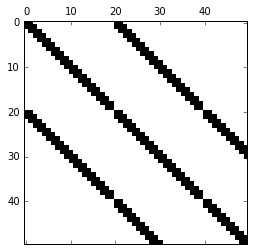

In [13]:
fig = plt.figure()
plt.spy(A[0:50, 0:50])
print numpy.max(A)
print numpy.min(A)

E, X = numpy.meshgrid(numpy.linspace(0,1,N*M), numpy.linspace(0,1,N*M))
# Plot solution
# fig = plt.figure()
# axes = fig.add_subplot(1, 1, 1)
# sol_plot = axes.pcolor(E, X, A)
# axes.set_title("Element of A")
# axes.set_xlabel("eta")
# axes.set_ylabel("xi")
# cbar = fig.colorbar(sol_plot, ax=axes)
# plt.show
print numpy.linalg.det(A)

In [14]:
for i in range(N):
    U_old[i*M: (i+1)*M] = numpy.maximum(numpy.ones(M) * S(xi[i]) - K , 0.0)

In [18]:
t = 0
t += delta_t
while t < t_final:
    U_new = numpy.linalg.solve(A, U_old + rhs)
    U_old = numpy.copy(U_new)
    t += delta_t

# for timestep in t:
#     U_new = numpy.linalg.solve(A, U_old + rhs)
#     print numpy.linalg.norm(U_old + rhs, 2)
#     assert( numpy.allclose(numpy.dot(A, U_new), U_old+rhs) == 1)
#     U_old = numpy.copy(U_new)

Reshape the U vector

In [19]:
U_sol = numpy.reshape(U_new, [N, M])

0.0941508665074 1958.22544425
4392.87374594


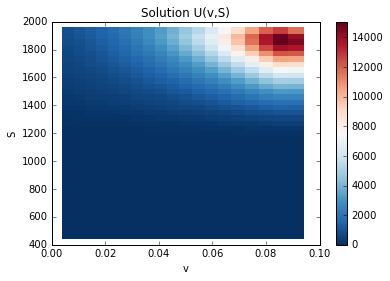

In [20]:
E, X = numpy.meshgrid(v(eta), S(xi))
#E, X = numpy.meshgrid(eta, xi)
# fig = plt.figure()
# # Plot right boundary condition
# axes = fig.add_subplot(1, 1, 1)
# axes.plot(xi, S(xi), 'o')

# fig = plt.figure()
# axes = fig.add_subplot(1, 1, 1)
# axes.plot(eta, v(eta), 'o')
# Plot solution
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
sol_plot = axes.pcolor(E, X, U_sol, cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Solution U(v,S)")
axes.set_xlabel("v")
axes.set_ylabel("S")
cbar = fig.colorbar(sol_plot, ax=axes)
# Plot initial data
# fig = plt.figure()
# axes = fig.add_subplot(1, 1, 1)
# sol_plot = axes.pcolor(E, X, numpy.reshape(U_init, [N, M]), cmap=plt.get_cmap('RdBu_r'))
# axes.set_title("Solution U(v,S)")
# axes.set_xlabel("v")
# axes.set_ylabel("S")
# cbar = fig.colorbar(sol_plot, ax=axes)
# plt.show()

print v(eta[-1]), S(xi[-1])
print U_sol[-1,-1]

In [25]:
U_true = numpy.empty([N,M])
for i in range(N):
    for j in range(M):
        U_true[i,j] = Exact_Solution(S(xi[i]), v(eta[j]))

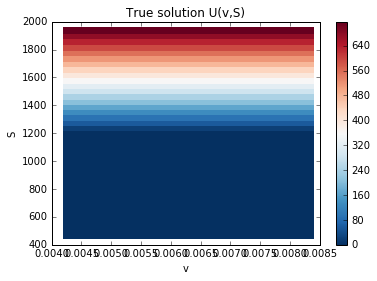

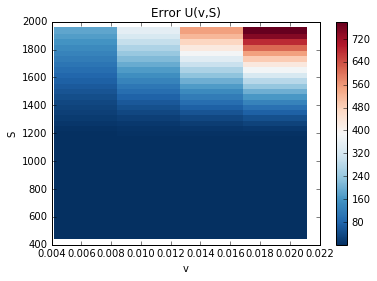

In [22]:
E, X = numpy.meshgrid(v(eta[0:2]), S(xi))
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
sol_plot = axes.pcolor(E, X, U_true[:,0:2], cmap=plt.get_cmap('RdBu_r'))
axes.set_title("True solution U(v,S)")
axes.set_xlabel("v")
axes.set_ylabel("S")
cbar = fig.colorbar(sol_plot, ax=axes)

E, X = numpy.meshgrid(v(eta[:5]), S(xi))
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
sol_plot = axes.pcolor(E, X, numpy.abs(U_true[:,:5] - U_sol[:,:5]), cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Error U(v,S)")
axes.set_xlabel("v")
axes.set_ylabel("S")
cbar = fig.colorbar(sol_plot, ax=axes)
plt.show()